# Project 1: Navigation
## Introduction
The goal of this project is to train an agent to navigate and collect bananas in a large, square world. 

The reward function is defined as +1 for collecting a yellow banana, and -1 for collecting a blue banana. The agent's objective is to maximize this score, with an average of 13 over 100 epochs being considered a "successful" agent.

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

## Set up Environment

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## Q Network
Our architecture here is quite simple - this is a neural network with only two fully-connected hidden layers and an output layer which indicates what action should be taken.

In [5]:
class QNetwork(nn.Module):
    """Actor Model"""
    
    def __init__(self, state_size, action_size):
        """Initialize parameters and build the model
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values"""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Deep Q agent
Our agent here is written to support both Q-learning and Double Q-learning. The difference between the two stems from the update step, where the deep q-learning agent will update the weights of the action-value network at each iteration, while the double q-learning agent updates the action-value network only every n iterations. 

The rationale for having this second network which is updated less frequently is that the learning is more stable, and  mitigates the problem of Q values being overestimated early in training. It does this by having a single set of weights for selecting actions and a second set of weights for evaluation. This slightly-frozen set of parameters also confers the benefits of fixed TD targets in adequately decoupling the weight update from the function parameter, which also smooths the training of the network.

In [6]:
BUFFER_SIZE = 100000    # Replay Buffer Size
BATCH_SIZE = 64         # Mini-batch Size
GAMMA = .99             # Discount Rate
TAU = .001              # Soft Update of Target Parameters
ALPHA = .0005           # Learning Rate
UPDATE_FREQ = 5         # How often to update network parameters

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
class ReplayBuffer():
    """Buffer to replay experience tuples"""
    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize ReplayBuffer class
        
        Params
        ======
            action_size (int): Dimension of each action
            buffer_size (int): Length of replay buffer
            batch_size (int): Size of each training mini-batch.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add_experience(self, state, action, reward, next_state, done):
        """Append an experience to memory"""
        exp = self.experience(state, action, reward, next_state, done)
        self.memory.append(exp)
        
    def sample(self):
        """Sample experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the length of the memory"""
        return len(self.memory)
    
    
class Agent():
    """Interacts with environment and learns from interactions"""
    
    def __init__(self, qnetwork, state_size, action_size, update_type='dqn', gamma=1.0, alpha=0.5, tau=.001):
        """Initialize the agent
        
        Params
        ======
            qnetwork (torch.nn.Module): Model to use as a function approximator
            state_size: Dimension of each state
            action_size: Dimension of each action
            update_type (str): 'dqn' or 'double-dqn' - specify the agent type
        """
        self.state_size = state_size
        self.action_size = action_size
        self.update_type = update_type if update_type in ['dqn', 'double-dqn'] else 'dqn' #Error handling
        self.discount_rate = gamma
        self.tau = tau
        
        # Q-network
        self.qnetwork_local = qnetwork(state_size, action_size).to(device)
        self.qnetwork_target = qnetwork(state_size, action_size).to(device)
        self.optimizer = torch.optim.Adam(self.qnetwork_local.parameters(), lr=alpha)
        
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        # Add experience to memory
        self.memory.add_experience(state, action, reward, next_state, done)
        
        # Learn according to update frequency
        self.t_step = (self.t_step + 1) % UPDATE_FREQ
        if self.t_step == 0:
            # Ensure there are enough experiences in memory to sample from
            if len(self.memory) >= BATCH_SIZE:
                exp = self.memory.sample()
                self.train(exp)
    
    def act(self, state, epsilon=0.0):
        """ Return actions for given state according to policy
        
            Params
            ======
            state (array_like): current environment state
            epsilon (float): Probability for epsilon-greedy policy
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        if np.random.uniform(0, 1) > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    
    def soft_update(self, local_network, target_network):
        """ Soft update model parameters 
            Theta_target = tau * Theta_local + (1 - tau) * Theta_target
        
            Params
            ======
                local_network (Torch model): weights to be copied from
                target_network (Torch model): weights to copy to
        """
        for target, local in zip (target_network.parameters(), local_network.parameters()):
            target.data.copy_(self.tau * local.data + (1.0 - self.tau) * target.data)
        
    def train(self, experiences):
        """ Update parameters via experience tuples
        
            Params
            ======
            experiences (Tuple): tuple of (state, action, reward, next_state, done) tuples
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Get max Q values for next states
        if self.update_type == 'dqn':
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
            
        if self.update_type == 'double-dqn':
            best_local_actions = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
            double_dqn_targets = self.qnetwork_target(next_states)
            Q_targets_next = torch.gather(double_dqn_targets, 1, best_local_actions)
        
        # Discounted Q targets for current state
        Q_targets = rewards + (self.discount_rate * Q_targets_next * (1-dones))
        
        # Expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions.long())
        
        # Compute and minimize mean squared error
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target)

In [9]:
agent = Agent(QNetwork, state_size, action_size,'double-dqn', GAMMA, ALPHA, TAU)

In [10]:
def learn(agent, episodes, max_t, epsilon_max=1.0, epsilon_min=0.01, epsilon_decay=0.999):
    """ Deep Q-learning
        
        Params
        ======
            episodes (int): Number of training episodes
            max_t (int): Upper limit of timesteps per episode
            epsilon_max (float): Starting value of epsilon
            epsilon_min (float): Minimum value of epsilon
            epsilon_decay (float): How much to decay epsilon by each episode
    """
    scores = []  # List of scores from each episode
    
    epsilon = epsilon_max  # Initialize epsilon
    
    for ep in tqdm_notebook(range(episodes)):
        info = env.reset(train_mode=True)[brain_name]  # Reset the environment
        state = info.vector_observations[0]  # Initial state
        score = 0  # Set score for episode to 0.
        
        for t in range(max_t):
            action = agent.act(state, epsilon)  # Select the action according to e-greedy policy
            info = env.step(action)[brain_name]  # Take the action and record state
            next_state = info.vector_observations[0]  # Get next state
            reward = info.rewards[0]  # Get the rewards
            done = info.local_done[0]  # Is the episode complete?
            
            agent.step(state, action, reward, next_state, done)  # Record the step in the agent
            score += reward  # Add rewards to the score
            
            state = next_state  # Update the state
            
            if done:
                break
        
        scores.append(score)
        epsilon = max(epsilon_min, epsilon*epsilon_decay)
        average_score = np.mean(scores[-100:])
        if (ep + 1) % 100 == 0:
            print("Episode {}\tAverage score: {:.2f}\n".format(ep+1, average_score))
        
        if average_score >= 13:
            print("Environment solved in {} episodes - average score {:.2f}".format(ep+1, average_score))
            torch.save(agent.qnetwork_local.state_dict(), 'solution.pth')
            break
        
    return scores

In [11]:
scores = learn(agent, 5000, 2000, 1.0, 0.1, .995)

/home/erick/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Episode 50	Average score: -0.24

Episode 100	Average score: 0.29

Episode 150	Average score: 1.64

Episode 200	Average score: 3.96

Episode 250	Average score: 5.94

Episode 300	Average score: 7.08

Episode 350	Average score: 8.86

Episode 400	Average score: 11.10

Episode 450	Average score: 12.61

Environment solved in 465 episodes - average score 13.01


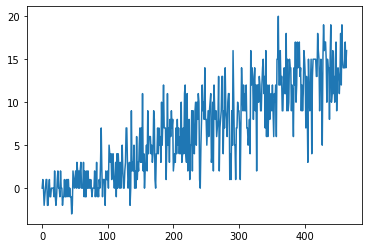

In [12]:
plt.plot(scores)